In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# GPU check (optional)
import torch, sys
print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Torch : 2.7.1+cpu
CUDA available: False


ModuleNotFoundError: No module named 'google.colab'

In [2]:
# === EDIT THESE 3 PATHS ===
CKPT_PATH   = "/content/drive/MyDrive/rtk_resnet/resnet18_rtk_best.pth"  # PyTorch checkpoint (state_dict)
LABELS_PATH = "/content/drive/MyDrive/rtk_resnet/class_names.json"       # class names in the same order
TS_PATH     = "/content/drive/MyDrive/rtk_resnet/resnet18_rtk_scripted.pt"  # (optional) TorchScript model


In [3]:
!pip -q install --upgrade torch torchvision pillow

In [4]:
import json, os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224

# Preprocessing (must match training)
preproc = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# Load labels
with open(LABELS_PATH, "r") as f:
    CLASS_NAMES = json.load(f)
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

# Try to load TorchScript first (if available), else fall back to .pth state_dict
model = None
if os.path.isfile(TS_PATH):
    try:
        print("Loading TorchScript model:", TS_PATH)
        model = torch.jit.load(TS_PATH, map_location=device).eval().to(device)
    except Exception as e:
        print("TorchScript load failed, falling back to .pth:", e)

if model is None:
    print("Loading PyTorch checkpoint:", CKPT_PATH)
    # Build same architecture and load state_dict
    m = models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, NUM_CLASSES)
    ckpt = torch.load(CKPT_PATH, map_location=device)
    state = ckpt["model_state"] if "model_state" in ckpt else ckpt
    m.load_state_dict(state)
    model = m.eval().to(device)

@torch.no_grad()
def predict_pil(img: Image.Image):
    x = preproc(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1).squeeze(0).cpu().tolist()
    i = int(torch.argmax(logits, dim=1))
    label = CLASS_NAMES[i]
    road_type, condition = label.split("_", 1) if "_" in label else (label, "unknown")
    return {
        "label": label,
        "type": road_type,
        "condition": condition,
        "confidence": float(probs[i]),
        "probs": {name: float(p) for name, p in zip(CLASS_NAMES, probs)},
    }


Classes: ['asphalt_bad', 'asphalt_good', 'asphalt_regular', 'paved_bad', 'paved_regular', 'unpaved_bad', 'unpaved_regular']
Loading TorchScript model: /content/drive/MyDrive/rtk_resnet/resnet18_rtk_scripted.pt


In [5]:
from google.colab import files
uploaded = files.upload()  # choose any image from your computer

# Use the first uploaded file
img_path = next(iter(uploaded.keys()))
print("Uploaded:", img_path)

res = predict_pil(Image.open(img_path).convert("RGB"))
res


Saving test1.jpg to test1.jpg
Uploaded: test1.jpg


{'label': 'asphalt_regular',
 'type': 'asphalt',
 'condition': 'regular',
 'confidence': 0.7123626470565796,
 'probs': {'asphalt_bad': 0.004262460395693779,
  'asphalt_good': 0.24578991532325745,
  'asphalt_regular': 0.7123626470565796,
  'paved_bad': 0.005446108058094978,
  'paved_regular': 0.022053325548768044,
  'unpaved_bad': 0.007909148931503296,
  'unpaved_regular': 0.002176446607336402}}

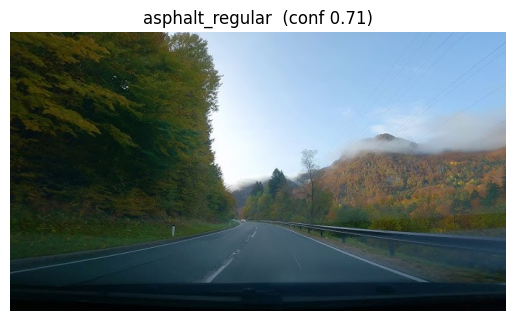

In [6]:
import matplotlib.pyplot as plt
def show_with_pred(img_path, res):
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img); plt.axis("off")
    title = f"{res['label']}  (conf {res['confidence']:.2f})"
    plt.title(title)
    plt.show()

# Example: show the last tested path (choose one used above)
try:
    show_with_pred(img_path, res)          # from upload
except:
    try:
        show_with_pred(drive_img_path, res)  # from drive
    except:
        pass


In [8]:
!pip -q install gradio --upgrade
import gradio as gr
from PIL import Image
import numpy as np
import os

def infer(img_input):
    """
    Accepts:
      - str: file path from gradio (type='filepath')
      - dict: newer gradio formats may wrap {'image': np.ndarray, ...}
      - np.ndarray: image array (type='numpy')
      - PIL.Image.Image
    Returns prediction dict from predict_pil(...)
    """
    # Normalize input to PIL.Image
    pil = None
    if isinstance(img_input, str) and os.path.exists(img_input):
        pil = Image.open(img_input).convert("RGB")
    elif isinstance(img_input, dict) and "image" in img_input:
        pil = Image.fromarray(img_input["image"]).convert("RGB")
    elif isinstance(img_input, np.ndarray):
        pil = Image.fromarray(img_input).convert("RGB")
    elif isinstance(img_input, Image.Image):
        pil = img_input.convert("RGB")
    else:
        raise ValueError("Unsupported input format for image")

    res = predict_pil(pil)  # uses the function defined earlier
    return {
        "label": res["label"],
        "type": res["type"],
        "condition": res["condition"],
        "confidence": round(res["confidence"], 3),
        "probs": {k: round(v, 4) for k, v in res["probs"].items()}
    }

# Use type='numpy' to avoid path quirks across environments
demo = gr.Interface(
    fn=infer,
    inputs=gr.Image(type="numpy", label="Upload road image"),
    outputs=gr.JSON(label="Prediction"),
    title="Road Condition Classifier (ResNet18)"
)

demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d3415a77b43a3614bb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8a38d276fd0d44524c.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://d3415a77b43a3614bb.gradio.live
